In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

plotarr = np.loadtxt("exhaustive_4.txt")
plotarr = np.reshape(plotarr,(10,78,3))

plotarr[plotarr<0] = 0
plt.figure()
for i in range(0,plotarr.shape[0]):
    plt.plot(plotarr[i,:,0],plotarr[i,:,2],label = str(plotarr[i,1,1]))
plt.legend()
plt.xlabel("Q")
plt.ylabel("Net profit")
plt.show()

In [ ]:


"""
Consider the same system as that described in Assignment 1 (a simple inventory model).

    2. Consider an alternate, simpler inventory replenishment policy where the retail store places bulk
    orders for Q items periodically after fixed time intervals T . (Q and T are simulation parameters).
    Find out the optimal values of Q and T using simulation. Compare the performance of the (s, S) policy 
    with this policy for the best possible parameter values.

[1] ASSUMPTIONS:
    (1) Inventory Level is not checked before ordering the items
    (2) Inventory can hold infinite items

[2] ASSUMPTIONS:
    (1) Inventory Level is checked before ordering the items
        (a) If Inventory has space to accumulate Q items then Q items are ordered, otherwise
        (b) (Inv_capacity - Inv_level) number of items are ordered
    (2) Inventory can hold max 500 items
"""

import numpy as np
import simpy
import matplotlib.pyplot as plt
import sys,os

# input parameters
ARR_RATE_LAMBDA = 10 # arrival rate of the customer
INV_STORE = [300, 600] # Inventory capacity (s,S)
DELIVERY_TIME = 2 # delivery time from distributor to retailer
DELIVERY_COST = 1000 # delivery cost per shipment
INV_HOLD_COST = 5 # inventory holding cost
PROFIT_PER_ITEM = 100 # profit earned per item
LAMBDA_REDUCE = 0.001 # 0.1 % reduction in the arrival rate, if a customer has to wait
PURCHASE_LIM = (1,10)
NUM_OF_DAYS = 1000

# simple replenishment policy with Q items every T days
Q = 400 # number items order
T = 5 # period

# variable to record stats
profit = 0
total_item_sold = []
inventory_levels = []
supply_chain_inv_hold_cost = []
supply_chain_delivery_cost = []
supply_chain_cost = []
lambda_rec = []
demand_per_day = 0
demand_per_day_rec = []
customer_who_waited = 0
total_customers = 0

# This is customer class
# obj of this class represents a customer
# the customer can have one retailer
class Customer:
    def __init__(self, env, purchase_lim, retailer, id_num):
        self.order_count = np.random.randint(low=purchase_lim[0],high=purchase_lim[1],size=1)[0]
        self.env = env
        self.retailer = retailer
        self.id_num = id_num
        
    def place_order(self, env):
        # customer places order
        # gets the items, pays for it and leaves
        # if number of items are not available then waits
        global profit, total_item_sold, lambda_rec, ARR_RATE_LAMBDA, demand_per_day, customer_who_waited
        
        # record customer demand 
        demand_per_day += self.order_count
        
        time_now = self.env.now
        # get the number of items from the inventory
        #print(f"customer {self.id_num} requested {self.order_count} units at {time_now}")
        yield self.retailer.item_store.get(self.order_count)
        if(time_now != self.env.now):
            # customer waited to get the order fulfilled
            #print(f"customer {self.id_num} waited, got at {self.env.now}")
            # this customer is likely to never return to the store
            ARR_RATE_LAMBDA = ARR_RATE_LAMBDA - ARR_RATE_LAMBDA*LAMBDA_REDUCE
            lambda_rec.append(ARR_RATE_LAMBDA)
            customer_who_waited += 1 
            print("arrival rate dec to = ",ARR_RATE_LAMBDA)
        
        # pay the cost for the items
        profit += self.order_count*PROFIT_PER_ITEM
        total_item_sold[-1] += self.order_count

# this is a retailer class
# obj of this class represents a retailer
# the retailer can have one supplier
class Retailer:
    def __init__(self, env, distributor):
        global INV_STORE
        self.env = env
        # this retailer has its own inventory 
        self.item_store = simpy.Container(self.env,capacity=INV_STORE[1],init=INV_STORE[0])
        self.distributor = distributor
    
    def place_order(self, env):
        global supply_chain_cost, INV_HOLD_COST, INV_STORE, Q, T
        while(True):
            # place order for Q items
            print(f"order place for Q = {Q} items at {self.env.now}")
            self.env.process(self.get_delivery(env))
            # wait for T days to place next order
            yield(self.env.timeout(T))
    
    def get_delivery(self,env):
        # order has been placed
        # wait for delivery of items => deliver in DELIVERY_TIME day(s)
        yield self.env.timeout(DELIVERY_TIME)
        # get the delivered items in inventory
        print(f"delivery at {self.env.now}")
        self.item_store.put(Q)
        supply_chain_cost[-1] += DELIVERY_COST

# this is a distributor class
# obj of this class represents a distributor
# it can place order at his supplier
# for time being it is passive, since supply chain does not have a supplier
class Distributor:
    def __init__(self, env):
        self.env = env

        
# this function simulates the arrival of the customers 
# arrival follows Poisson distribution with arrival rate lambda
def customer_arrivals(env,retailer):
    global inventory_levels, demand_per_day, demand_per_day_rec, total_item_sold, total_customers
    cust_num = 0
    while(True):
        total_item_sold.append(0)
        supply_chain_cost.append(0)
        num_of_cust = np.random.poisson(lam=ARR_RATE_LAMBDA, size=1)[0]
        total_customers += num_of_cust
        for i in range(0,num_of_cust):
            customer_i = Customer(env,PURCHASE_LIM,retailer,cust_num)
            env.process(customer_i.place_order(env))
            cust_num += 1
        
        print("at ",env.now,": demand = ",demand_per_day,", inv lvl = ", retailer.item_store.level)
        # record the inventory levels at the end of the day
        inventory_levels.append(retailer.item_store.level)
        demand_per_day_rec.append(demand_per_day)
        demand_per_day = 0
        supply_chain_cost[-1] += retailer.item_store.level*INV_HOLD_COST
        
        yield env.timeout(1)

def single_sim_run(NUM_OF_DAYS,print_log=False):
    global profit, total_item_sold, inventory_levels, supply_chain_inv_hold_cost, supply_chain_delivery_cost, supply_chain_cost, lambda_rec, demand_per_day, demand_per_day_rec, customer_who_waited, total_customers, ARR_RATE_LAMBDA
    # reinit all variables to record stats
    ARR_RATE_LAMBDA = 10
    profit = 0
    total_item_sold.clear()
    inventory_levels.clear()
    supply_chain_inv_hold_cost.clear()
    supply_chain_delivery_cost.clear()
    supply_chain_cost.clear()
    lambda_rec.clear()
    demand_per_day = 0
    demand_per_day_rec.clear()
    customer_who_waited = 0
    total_customers = 0
    #print(f"profit = {profit}, {sum(supply_chain_cost)}")
    old_stdout = sys.stdout
    if(not print_log):
        sys.stdout = open(os.devnull, 'w')
        
    env = simpy.Environment()
    distributor = Distributor(env)
    retailer = Retailer(env,distributor)
    env.process(retailer.place_order(env))
    env.process(customer_arrivals(env,retailer))
    env.run(NUM_OF_DAYS)
    
    sys.stdout = old_stdout
    
    # calculate stats 
    # avg profit per day
    P_avg = profit/NUM_OF_DAYS
    
    # avg supply chain cost per day
    C_avg = sum(supply_chain_cost)/NUM_OF_DAYS
    
    # Time-averaged number of items in the inventory
    I_avg = []
    for i in range(len(inventory_levels)):
        I_avg.append([i+1,sum(inventory_levels[0:i+1])/(i+1)])
        
    # Throughput (average number of items sold per-day)
    T_avg = sum(total_item_sold)/NUM_OF_DAYS
    
    # Monthly Inventory turnover ratio (R)
    turnover_ratio_R = []
    inx = 0
    for i in range(30,NUM_OF_DAYS,30):
        turnover_ratio_R.append(sum(total_item_sold[inx:i])/I_avg[i][1])
        inx = i
    
    # Fraction of customers that do not return
    customer_left = customer_who_waited/total_customers
    
    # Net avg profit per-day
    P_net = P_avg - C_avg
    
    return P_avg, C_avg, I_avg, T_avg, turnover_ratio_R, customer_left, P_net

plotarr = []
net_avg_profit = []
T_BOUNDS = [1,11]
Q_BOUNDS = [10,400]
q_step = 5
NUM_OF_SIMS = 100

for temp_T in range(T_BOUNDS[0],T_BOUNDS[1]):
    plotarr.append([])
    T = temp_T
    for temp_Q in range(Q_BOUNDS[0],Q_BOUNDS[1],q_step):
        Q = temp_Q
        net_avg_profit.append(0)
        for i in range(0,NUM_OF_SIMS):
            P_avg, C_avg, I_avg, T_avg, turnover_ratio_R, customer_left, P_net = single_sim_run(NUM_OF_DAYS)
            net_avg_profit[-1] += P_net
            #print(f"profit={P_avg},cost={C_avg},throughput={T_avg}")
        net_avg_profit[-1] = net_avg_profit[-1]/NUM_OF_SIMS
        print(f"net avg profit = {net_avg_profit[-1]}, with Q = {Q}, T = {T}")
        plotarr[-1].append([Q,T,net_avg_profit[-1]])

plotarr = np.array((plotarr))

In [ ]:
plotarr = np.reshape(plotarr,(10,78,3))

In [ ]:
%matplotlib notebook
for i in range(0,10):
    plt.plot(plotarr[i,:,0],plotarr[i,:,2],label="T="+str(plotarr[i,1,1]))
plt.legend()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

filename = 'supplychain_data_clean.csv'
df = pd.read_csv(filename)
data = df[['S_D1','s_D1','S_D2','s_D2','S_R1','s_R1','S_R2','s_R2','avg_net_profit']].values
data = np.array(data)

#finding unique values
SD = np.unique(data[:,0])
sD = np.unique(data[:,1])

inx_i = 1
inx_j = 4
print(f"SD = {SD}, sD = {sD}")
data_sec = data[data[:,0]==SD[inx_i]]
data_sec = data_sec[data_sec[:,1]==sD[inx_j]]
print(f"Slice at S_D = {SD[-1]}, s_D = {sD[inx_j]}, section size = {data_sec.shape}")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_trisurf(data_sec[:,4],data_sec[:,5], data_sec[:,8],color='c',alpha=0.85,antialiased=True)
plt.xlabel("S_R")
plt.ylabel("s_R")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#%matplotlib notebook

filename = 'supplychain_data_clean.csv'
df = pd.read_csv(filename)
data = df[['S_D1','s_D1','S_D2','s_D2','S_R1','s_R1','S_R2','s_R2','avg_net_profit']].values
data = np.array(data)

#finding unique values
SD = np.unique(data[:,0])
sD = np.unique(data[:,1])

inx_i = -1
inx_j = 4
print(f"SD = {SD}, sD = {sD}")
data_sec = data[data[:,0]==SD[inx_i]]
data_sec = data_sec[data_sec[:,1]==sD[inx_j]]
print(f"Slice at S_D = {SD[-1]}, s_D = {sD[inx_j]}, section size = {data_sec.shape}")

SR = np.unique(data_sec[:,4])
sR = np.unique(data_sec[:,5])
x = []
y = []
z = []
min_val = min(data_sec[:,8])
for i in SR:
    x.append([])
    y.append([])
    z.append([])
    for j in sR:
        x[-1].append(i)
        y[-1].append(j)
        temp = data_sec[data_sec[:,4]==i,:]
        z_temp = temp[temp[:,5]==j,8]
        if(len(z_temp)==0):
            #z_temp = min_val
            z_temp = min(temp[:,8])
        else:
            z_temp = z_temp[0]
        #print(i,j,z_temp)
        z[-1].append(z_temp)
        
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Slice at given SD,sD', autosize=True,
                  width=500, height=500)
fig.show()

In [2]:
import SupplyChainModelv2 as model
import numpy as np
import pandas as pd
import os
from csv import writer

distributor1 = {'name':'D1',
                'S': 500, # inventory capacity
                's': 350, # inventory threshold
                'H': 1, # inventory holding cost
                'C': [500], # delivery cost from manufacturer
                'D': [7] # delivery time
               }

distributor2 = {'name':'D2',
                'S': 500,
                's': 350,
                'H': 1,
                'C': [500],
                'D': [8]}

retailer1 = {'name':"R1",
             'S': 500,
             's': 300,
             'H': 10,
             'C':[5000,6000], # delivery cost per distributor
             'D':[2,3] # delivery time per distributor
            } 
retailer2 = {'name':"R2",
             'S': 500,
             's': 300,
             'H': 10,
             'C':[7000,5500],
             'D':[3,2]}

R_list = [retailer1,retailer2]
D_list = [distributor1,distributor2]

# this fun sets the design parameters of the supply chain

def N_sim_runs(D_list,R_list,
               S_D1, s_D1, S_D2, s_D2, S_R1, s_R1, S_R2, s_R2,
               arr_rate,p,NUM_OF_DAYS,Profit,
               NUM_OF_SIMS):
    R_list[0]['S'] = S_R1
    R_list[0]['s'] = s_R1
    R_list[1]['S'] = S_R2
    R_list[1]['s'] = s_R2
    D_list[0]['S'] = S_D1
    D_list[0]['s'] = s_D1
    D_list[1]['S'] = S_D2
    D_list[1]['s'] = s_D2
    
    avg_stats = []
    avg_nstats = []
    for i in range(NUM_OF_SIMS):
        frac_cust_ret, avg_profit, avg_hold_c, avg_del_c, timed_avg_nitems, avg_net_profit, nwise_stats = model.single_sim_run(lam=arr_rate, D_list=D_list, R_list=R_list, p=p, NUM_OF_DAYS=NUM_OF_DAYS, P=Profit)
        avg_stats.append([frac_cust_ret, avg_profit, avg_hold_c, avg_del_c, timed_avg_nitems, avg_net_profit])
        for i in range(len(nwise_stats)):
            if(len(avg_nstats)<=i):
                nwise_stats[i].pop(0)
                avg_nstats.append([x/NUM_OF_SIMS for x in nwise_stats[i]])
            else:
                for j in range(1,len(nwise_stats[i])):
                    avg_nstats[i][j-1] = avg_nstats[i][j-1] + nwise_stats[i][j]/NUM_OF_SIMS

    avg_stats = np.array((avg_stats))
    avg_stats = np.mean(avg_stats,axis=0)
    temp = []
    for i in avg_nstats:
        for j in i:
            temp.append(j)
    return [S_R1,s_R1,S_R2,s_R2,S_D1,s_D1,S_D2,s_D2,*avg_stats,*temp]

# parameters
lambda_arr_rate = 20
p = [0.5,0.5]
Profit = 100
num_days = 30
num_sims = 50

in_param_pd = pd.read_csv('in_params.csv')
in_param_arr = np.array((in_param_pd.values))

for i in in_param_arr[:8]:
    avg_stats = N_sim_runs(D_list=D_list,R_list=R_list,
               S_D1=i[0], s_D1=i[1], S_D2=i[2], s_D2=i[3], S_R1=i[4], s_R1=i[5], S_R2=i[6], s_R2=i[7],
               arr_rate=lambda_arr_rate,p=p,NUM_OF_DAYS=num_days,Profit=Profit,NUM_OF_SIMS=num_sims)
    with open('supplychain_datav2cp.csv', 'a',newline='') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow([lambda_arr_rate, Profit, num_days, num_sims, (p[0],p[1]), *avg_stats])
        f_object.close()


In [2]:
# generaitng input parameter values for supply chain
import numpy as np
import pandas as pd
from csv import writer

# the following code is to print the values

#in_param_pd = pd.read_csv('in_params.csv')
#in_param_arr = np.array((in_param_pd.values))
#for i in range(0,in_param_arr.shape[1]):
#    print(in_param_pd.columns[i],np.unique(in_param_arr[:,i]))

bounds = {
    "SD1":(720,740),
    "sD1":[470,490],
    "SD2":[720,740],
    "sD2":[470,490],
    "SR1":[310,330],
    "sR1":[115,135],
    "SR2":[310,330],
    "sR2":[115,135]
}
step = 5
filename = "in_params_for_opti_itr2.csv"
with open(filename, 'a',newline='') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(['SD1','sD1','SD2','sD2','SR1','sR1','SR2','sR2'])
    f_object.close()

for SD1 in [732,721]:#range(bounds["SD1"][0],bounds["SD1"][1],step):
    for sD1 in [472,482]:#range(bounds["sD1"][0],bounds["sD1"][1],step):
        for SD2 in [722,731,732]:#range(bounds["SD2"][0],bounds["SD2"][1],step):
            for sD2 in [471,472,482]:#range(bounds["sD2"][0],bounds["sD2"][1],step):
                for SR1 in [312,322]:#range(bounds["SR1"][0],bounds["SR1"][1],step):
                    for sR1 in [117,127,128]:#range(bounds["sR1"][0],bounds["sR1"][1],step):
                        for SR2 in [310,312,322,323]:#range(bounds["SR2"][0],bounds["SR2"][1],step):
                            for sR2 in [117,127]:#range(bounds["sR2"][0],bounds["sR2"][1],step):
                                #print([SD1,sD1,SD2,sD2,SR1,sR1,SR2,sR2])
                                with open(filename, 'a',newline='') as f_object:
                                    writer_object = writer(f_object)
                                    writer_object.writerow([SD1,sD1,SD2,sD2,SR1,sR1,SR2,sR2])
                                    f_object.close()

In [3]:
# this snippet
# observed the optimum found by using metamodel based optimization (see file 'opti_using_meta_analysis_data.xlsx')
# and this input parameter list is generated to run the original model and compare the output

from csv import writer
with open('in_params_for_opti_nn.csv', 'a',newline='') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(['SD1','sD1','SD2','sD2','SR1','sR1','SR2','sR2'])
    f_object.close()
    
params_nn_opti_check = [[630,418,695,380,315,163,493,424],
                        [750,500,750,369,300,121,362,180],
                        [750,500,750,350,317,134,420,239],
                        [706,410,694,460,367,114,437,232],
                        [750,500,750,500,302,117,300,120],
                        [750,500,750,500,300,117,300,120],
                        [732,487,737,421,402,184,332,165],
                        [750,358,750,452,357,176,355,171],
                        [750,500,750,500,412,244,355,195]]

for par in params_nn_opti_check:
    with open('in_params_for_opti_nn.csv', 'a',newline='') as f_object:
            writer_object = writer(f_object)
            writer_object.writerow(par)
            f_object.close()

In [1]:
# fitting a metamodel
# csv file supplychain_datav2_720_60_llel.csv contains exhaustive eval data of supply chain 
# for input parameter values in param.csv
# this code sample x % data points from this exhaustive data and fits a gpr/nn metamodel
# this code is written for Atuin Server (80 core)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPRegressor
import random
import pandas as pd
import time
import multiprocessing as mp
import pickle
from joblib import parallel_backend

# import data
data = pd.read_csv("supplychain_datav2_720_60_llel.csv")

def fit_with_x_perc(train_data_perc):
    global data
    dt_arr = data[['S_R1','s_R1', 'S_R2', 's_R2', 'S_D1', 's_D1', 'S_D2', 's_D2', 'avg_net_profit']].copy()

    num_samples_percent = train_data_perc/100 # num of sample points is num_samples_percent % of whole data we created above

    # randomly sample some K training points
    k = int(data.shape[0]*num_samples_percent)
    indices = random.sample(range(0, data.shape[0]), k)
    X_train = dt_arr.values[indices,:8]
    y_train = dt_arr.values[indices,8]
    print(f"Training Data shape X = {X_train.shape}, shape y = {y_train.shape}")

    # Your scikit-learn code here
    # let us fit a GPR metamodel with RBF kerneli
    start_time = time.time()
    
    #with parallel_backend('threading', n_jobs=2):
    kernel = RBF(length_scale=1, length_scale_bounds=(40, 60))
    gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(X_train,y_train)

    print("train data = ",train_data_perc," exe time for fitting gpr = ", time.time()-start_time)
    filename = 'gpr_'+str(train_data_perc)+'_per_train.sav'
    pickle.dump(gpr, open(filename, 'wb'))

    # let us fit a MLP
    start_time = time.time()

    #with parallel_backend('threading', n_jobs=2):
    regr = MLPRegressor(hidden_layer_sizes=(32,32,16,16),
                        activation='relu',
                        solver='lbfgs',
                        random_state=1,
                        max_iter=1000).fit(X_train, y_train)
    print("train data = ",train_data_perc,"exe time for fitting gpr = ",time.time()-start_time)
    filename = 'NN_'+str(train_data_perc)+'_per_train.sav'
    pickle.dump(gpr, open(filename, 'wb'))

    gx1 = gpr.predict(data[['S_R1','s_R1', 'S_R2', 's_R2', 'S_D1', 's_D1', 'S_D2', 's_D2']].values)
    gx2 = regr.predict(data[['S_R1','s_R1', 'S_R2', 's_R2', 'S_D1', 's_D1', 'S_D2', 's_D2']].values)

    dt_arr['gx1'] = gx1
    dt_arr['gx2'] = gx2
    file_name = "metamodels_" + str(int(num_samples_percent*100))+".csv"
    dt_arr.to_csv(file_name,index=False)

#pool = mp.Pool()
#pool = mp.Pool(processes=6)

#pool.map(fit_with_x_perc,[35,40,45,50,55,60])

fit_with_x_perc(10)

Training Data shape X = (6553, 8), shape y = (6553,)


C:\Users\User\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 60. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


train data =  10  exe time for fitting gpr =  14.101046085357666


C:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:536: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


train data =  10 exe time for fitting gpr =  7.720027446746826


Text(0.5, 1.0, 'Goodness of fit NN')

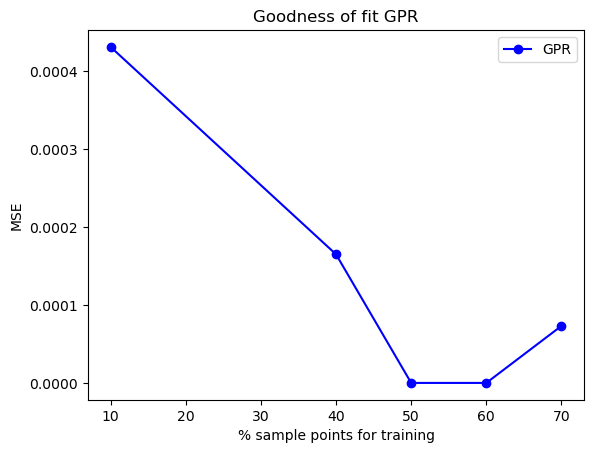

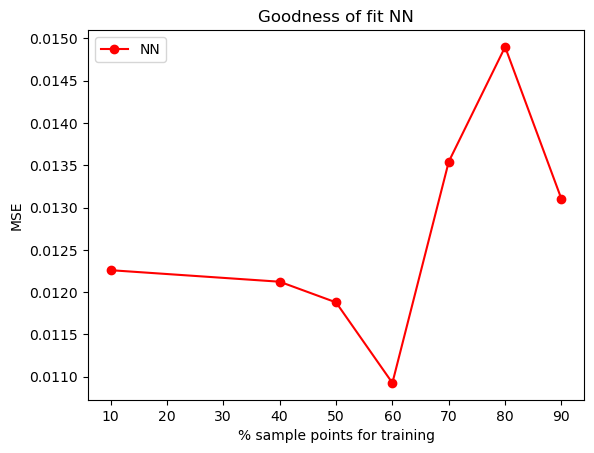

In [1]:
# calculating MSE for measuring the goodness of fit
# metamodel_gpr.csv, metamodel_nn.csv contains prections using gpr and nn metamodels with x % train data
# we calculate and summarize/visualize the goodness of fit
import pandas as pd
import numpy as np
data_gpr = pd.read_csv("metamodels_gpr.csv")
data_nn = pd.read_csv("metamodels_nn.csv")


def mse(x1,x2):
    if(len(x1)!=len(x2)):
        print("lengths do not match")
        return
    squared_sum = 0
    for i in range(0,len(x1)):
        squared_sum = (x1[i]-x2[i])**2
    return (1/len(x1))*np.sqrt(squared_sum)

names_models = ['10per','40per','50per','60per','90per','70per','80per']
mse_arr = []
for col in names_models:
    if(col in data_gpr.columns):
        mse_arr.append([int(col[:2]),mse(data_gpr['avg_net_profit'].values,data_gpr[col].values)])
        #print(mse_arr[-1])
mse_arr2 = []
for col in names_models:
    if(col in data_nn.columns):
        mse_arr2.append([int(col[:2]),mse(data_nn['avg_net_profit'].values,data_nn[col].values)])
        #print(mse_arr2[-1])
import matplotlib.pyplot as plt

mse_arr = np.array((mse_arr))
mse_arr2 = np.array((mse_arr2))

mse_arr = mse_arr[np.argsort(mse_arr,axis=0)[:,0]]
mse_arr2 = mse_arr2[np.argsort(mse_arr2,axis=0)[:,0]]

#print(mse_arr)
plt.figure()
plt.plot(mse_arr[:,0],mse_arr[:,1],marker='o',color='blue',label="GPR")
plt.xlabel("% sample points for training")
plt.ylabel("MSE")
plt.legend()
plt.title("Goodness of fit GPR")

#print(mse_arr2)
plt.figure()
plt.plot(mse_arr2[:,0],mse_arr2[:,1],marker='o',color='red',label="NN")
plt.xlabel("% sample points for training")
plt.ylabel("MSE")
plt.legend()
plt.title("Goodness of fit NN")

actual maxima =  [350. 150. 350. 150. 750. 450. 750. 450.]
actual maxima =  [350. 150. 350. 150. 750. 450. 750. 450.]


Text(0.5, 1.0, 'Goodness of fit NN')

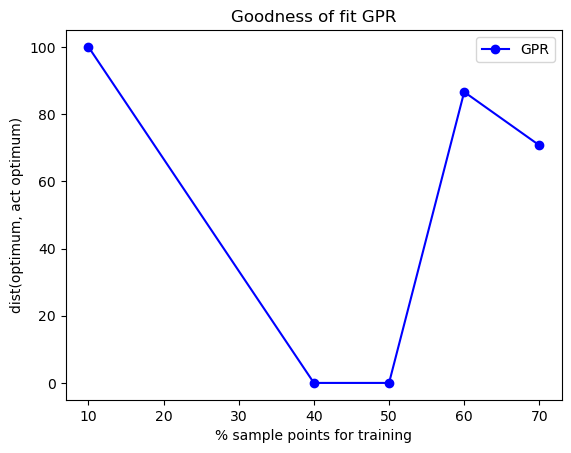

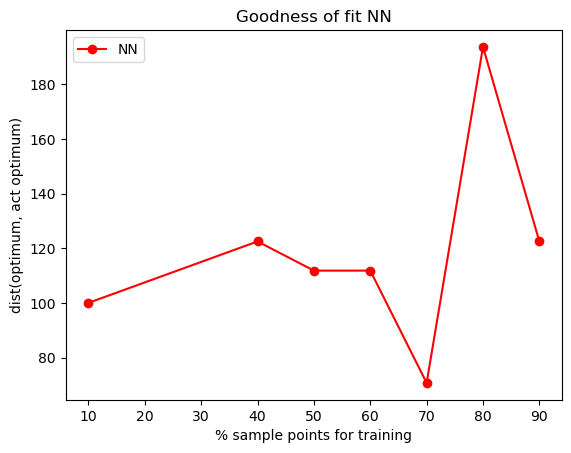

In [2]:
# dist from actual minimum
import math
cols_gpr = data_gpr.columns
cols_nn = data_nn.columns

data_gpr = np.array((data_gpr.values))
data_nn = np.array((data_nn.values))

arg_max_indices = np.argmax(data_gpr,axis=0)
actual_maxima = data_gpr[arg_max_indices[8],:8]
print("actual maxima = ",actual_maxima)
dist_arr = []
i = 9
for index in arg_max_indices[9:]:
    model_maxima = data_gpr[index,:8]
    dist_arr.append([int(cols_gpr[i][:2]),math.dist(model_maxima,actual_maxima)])
    i += 1
dist_arr = np.array((dist_arr))
plt.figure()
plt.plot(dist_arr[:,0],dist_arr[:,1],marker='o',color='blue',label="GPR")
plt.xlabel("% sample points for training")
plt.ylabel("dist(optimum, act optimum)")
plt.legend()
plt.title("Goodness of fit GPR")
    
    
arg_max_indices = np.argmax(data_nn,axis=0)
actual_maxima = data_nn[arg_max_indices[8],:8]
print("actual maxima = ",actual_maxima)
dist_arr = []
i = 9
for index in arg_max_indices[9:]:
    model_maxima = data_nn[index,:8]
    dist_arr.append([int(cols_nn[i][:2]),math.dist(model_maxima,actual_maxima)])
    i += 1
dist_arr = np.array((dist_arr))
plt.figure()
plt.plot(dist_arr[:,0],dist_arr[:,1],marker='o',color='red',label="NN")
plt.xlabel("% sample points for training")
plt.ylabel("dist(optimum, act optimum)")
plt.legend()
plt.title("Goodness of fit NN")

(60, 65537)


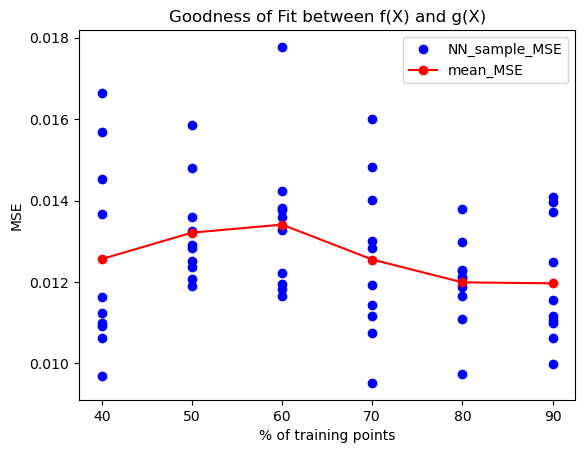

In [3]:
# visulaizing goodness of fit for x% training points

# 'metamodels_nn_mulitple_random_samples.csv' this data is recodered as below;
# x% of points are sampled from whole data (supplychain_datav2_720_60_llel.csv) (train data)
# NN/GPR Metamodel is fit
# prediction is made on all data
# 10 such random samples were taken for each value x in [40,50,60,70,80,90]
 
# loading the data
import numpy as np
data_gx = np.loadtxt("metamodels_nn_mulitple_random_samples.csv",delimiter=",", dtype=float)
print(data_gx.shape)

# function to calculate MSE
def mse(x1,x2):
    if(len(x1)!=len(x2)):
        print("lengths do not match")
        return
    squared_sum = 0
    for i in range(0,len(x1)):
        squared_sum = (x1[i]-x2[i])**2
    return (1/len(x1))*np.sqrt(squared_sum)

# load whole data (exhaustive evaluated)
import pandas as pd
data_fx = pd.read_csv("supplychain_datav2_720_60_llel.csv")
data_fx = data_fx[['S_R1','s_R1', 'S_R2', 's_R2', 'S_D1', 's_D1', 'S_D2', 's_D2', 'avg_net_profit']]
data_fx = np.array((data_fx.values))

# calculate MSE for all fits with different training sizes
mse_rec_arr = []

for i in np.unique(data_gx[:,0]):
    temp_dt = data_gx[data_gx[:,0]==i,:]
    #print(temp_dt.shape,temp_dt)
    for row in range(temp_dt.shape[0]):
        mse_rec_arr.append([i, mse(temp_dt[row,1:],data_fx[:,8])])

# plot and visualize
import matplotlib.pyplot as plt
mse_rec_arr = np.array((mse_rec_arr))
mean_mse = []
for i in np.unique(data_gx[:,0]):
    mean_mse.append(np.mean(mse_rec_arr[mse_rec_arr[:,0]==i,1]))
plt.plot(mse_rec_arr[:,0]*100,mse_rec_arr[:,1],marker='o',color='blue',linestyle='',label='NN_sample_MSE')
plt.plot(np.unique(data_gx[:,0])*100,mean_mse,marker='o',color='red',linestyle='-',label='mean_MSE')
plt.title("Goodness of Fit between f(X) and g(X)")
plt.xlabel("% of training points")
plt.ylabel("MSE")
plt.legend()
plt.show()

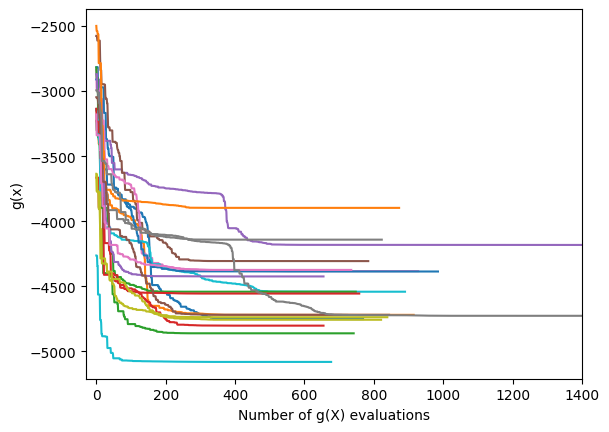

[770, 916, 743, 656, 1518, 785, 929, 824, 822, 891, 986, 874, 749, 759, 656, 845, 736, 1406, 840, 678]
869.15
X = 429.04, 120.27, 320.55, 123.57, 730.14, 475.15, 621.54, 478.74, g(x) =  -4752.7547746639275
X = 319.69, 124.44, 427.33, 121.77, 620.51, 372.11, 727.94, 373.22, g(x) =  -4720.202658386661
X = 321.13, 122.03, 321.88, 122.33, 623.32, 478.83, 731.36, 477.28, g(x) =  -4862.24746700579
X = 427.46, 121.05, 318.13, 124.53, 728.46, 478.71, 731.00, 372.21, g(x) =  -4803.212425975786
X = 317.14, 125.55, 423.07, 224.60, 623.72, 478.75, 626.17, 369.09, g(x) =  -4182.738514372667
X = 428.61, 214.70, 320.74, 124.50, 621.86, 369.57, 730.56, 476.70, g(x) =  -4306.979893340428
X = 425.27, 205.93, 319.83, 124.57, 728.94, 478.77, 729.62, 477.90, g(x) =  -4384.091005484636
X = 425.48, 121.39, 326.32, 114.38, 620.71, 479.28, 624.72, 480.76, g(x) =  -4142.013713156966
X = 320.78, 122.82, 426.82, 120.54, 729.50, 478.26, 726.76, 372.76, g(x) =  -4758.002135730803
X = 421.96, 125.45, 418.77, 124.35,

In [14]:
# this snippet is to estimate the optimum number of interations taken by an optimizer
# est_n_itr_opti.csv is loaded and plotted
# this file has data saved as
# [itr number, min at this itr]
# for different initial starting point
#%matplotlib notebook
import csv
import numpy as np
import matplotlib.pyplot as plt
optimum_x_ls = []
num_of_gx_evals = []
optimizer_names = ["COBYLA","SLSQP","Powell","Nelder-Mead"]
with open("opti_convergence_data/75gpr"+optimizer_names[3]+"_est_n_itr_opti.csv", 'r') as file:
    csvreader = csv.reader(file, delimiter=',')
    row_float = []
    for row in csvreader:
        if(len(row[0].split(','))>1):
            opti_x = row[-1]
            opti_x = opti_x[1:-1] # to remove '(' and ')'
            opti_x = opti_x.split(',')
            opti_x = [float(x) for x in opti_x]
            optimum_x_ls.append(opti_x)
            continue
        #if(float(row[-1])>-10000):
        num_of_gx_evals.append(len(row))
        row_float.append([])
        for item in row:
            row_float[-1].append(float(item))
        plt.plot(row_float[-1],marker='')

#plt.title("Num of itrs for "+optimizer_names[3]+" (GPR with 75% train pts)")
plt.xlabel("Number of g(X) evaluations")
plt.ylabel("g(x)")
plt.xlim([-30, 1400])
plt.show()

print(num_of_gx_evals)
print(sum(num_of_gx_evals)/len(num_of_gx_evals))

for i in range(0,len(row_float)):
    print("X = ",end="")
    for j in optimum_x_ls[i]:
        print(f"{j:.2f}",end=", ")
    print("g(x) = ",row_float[i][-1])

In [25]:
# run this snippet after above cell
# this just discards all optimums which are not within the specified bounds below
# lists the remaining and prints them

#bounds = [(300,450),(100,250),(300,450),(100,250),(600,750),(350,500),(600,750),(350,500)]
bounds = [(310,325),(115,130),(310,325),(115,130),(720,735),(470,485),(720,735),(470,485)]
i = 1
total_rows = len(row_float)
while len(row_float)>0:
    k = 0
    row_popped = False
    for j in optimum_x_ls[-i]:
        if(bounds[k][0]<=j<=bounds[k][1]):
            k+=1
        else:
            #pop the row
            print(f"popping {len(row_float)-i+1}th ele (k={k}): ({j:.2f}, {bounds[k]}), g={row_float[-i][-1]:.2f}, X:",end=" ")
            for m in optimum_x_ls[-i]:
                print(f"{m:.2f}",end=", ")
            print("")
            row_float.pop(-i)
            optimum_x_ls.pop(-i)
            num_of_gx_evals.pop(-i)
            row_popped = True
            break
    if(not row_popped):
        i+=1
    
for i in range(0,len(row_float)):
    print("X = ",end="")
    for j in optimum_x_ls[i]:
        print(f"{j:.2f}",end=", ")
    print("g(x) = ",row_float[i][-1])
    
print("remaining rows lengths",num_of_gx_evals)
if(len(num_of_gx_evals)>0):
    print(f"avg = {sum(num_of_gx_evals)/len(num_of_gx_evals):.2f}")

popping 20th ele (k=0): (397.14, (310, 325)), g=-3798.98, X: 397.14, 218.19, 374.38, 161.55, 727.10, 438.23, 759.89, 377.03, 
popping 19th ele (k=0): (402.18, (310, 325)), g=-3791.86, X: 402.18, 233.42, 398.24, 187.74, 700.83, 424.94, 756.81, 379.93, 
popping 18th ele (k=0): (415.93, (310, 325)), g=-3654.99, X: 415.93, 258.76, 365.28, 165.16, 651.35, 395.56, 725.93, 371.38, 
popping 17th ele (k=0): (365.15, (310, 325)), g=-3727.21, X: 365.15, 210.20, 409.42, 194.38, 732.63, 390.38, 763.80, 420.55, 
popping 16th ele (k=0): (431.43, (310, 325)), g=-4031.03, X: 431.43, 259.48, 422.16, 195.66, 709.48, 428.85, 817.08, 415.31, 
popping 15th ele (k=1): (166.85, (115, 130)), g=-3479.90, X: 322.72, 166.85, 396.57, 195.10, 645.08, 383.16, 716.52, 354.36, 
popping 14th ele (k=0): (367.97, (310, 325)), g=-3815.53, X: 367.97, 180.59, 419.31, 205.31, 748.89, 437.46, 769.31, 377.75, 
popping 13th ele (k=0): (380.87, (310, 325)), g=-3601.78, X: 380.87, 219.47, 322.27, 120.64, 628.58, 454.35, 748.30, 4

In [2]:
# This code snippet is to print stats found in opti_using_meta_stats.csv/opti_using_meta_stats_ms_box.csv
# a row contains all stats.
# data is generated by fit_meta_optimize_calculate_mse.py. (see it for better understanding)
import csv

with open("opti_using_meta_stats_ms_box.csv", 'r') as file:
    csvreader = csv.reader(file, delimiter=',')
    for row in csvreader:
        print(len(row))
        for i in range(0,17):
            print(row[i],end=",")
        print("\n")

65553
25,gpr,1,(1, 10),9.106927833979483e-05,728.8397011756897,COBYLA,322.76379781933895,128.09878823972173,322.96867385519045,127.85681069960714,721.9775553039044,472.0988200875633,732.9800949215944,471.9475517652125,-4126.764072046899,20.996074438095093,

65553
25,gpr,1,(1, 10),9.106927833979483e-05,728.8397011756897,Powell,312.1025002684181,117.25240144120015,312.1833708884481,117.0205928332354,732.9670147596927,482.9344042763514,732.851200695595,482.82118699192364,-4095.3013804961192,19.08510184288025,

65553
25,gpr,1,(1, 10),9.106927833979483e-05,728.8397011756897,SLSQP,383.0,106.0,321.0,103.0,655.0,372.0,731.0,496.0,-1.6745926320970819e-75,0.3710346221923828,

65553
25,gpr,1,(1, 10),9.106927833979483e-05,728.8397011756897,Nelder-Mead,322.9089367164242,127.9925635226543,322.87236293930147,127.88239647883648,732.8872232718752,472.099981701547,732.8811399591168,471.91826324374443,-4135.052630414037,34.58586311340332,

65553
50,gpr,1,(1, 10),0.0007717687803240614,3537.2557284832,COBY

65552
75,nn,(32, 32, 16, 16),0.00046640788724117144,41.065725564956665,SLSQP,300.0,250.0,450.0,100.0,750.0,500.0,750.0,350.0,-4204.448387968587,2.2090651988983154,3443.687830385395,

65552
75,nn,(16, 16, 8, 8),0.0004672867229847111,30.317785024642944,Nelder-Mead,-2.1371619095142235e+53,6.63486526926869e+52,-2.5340268054332366e+53,5.3939085345580864e+51,2.0239761837598085e+53,7.634003771488627e+52,6.312845937217792e+53,-1.8927848945999397e+53,-3.1642625397943414e+54,16.11732578277588,3443.708613231204,

65552
75,nn,(32, 16, 8, 8),0.0004648070741314625,52.02771973609924,Nelder-Mead,-3.5961167723205863e+53,5.853204146972942e+52,-2.447509346095306e+53,2.9155694526919285e+52,8.566746327742731e+52,1.9082577344239281e+53,6.74905624579184e+53,-1.5809704156771615e+53,-3.3934737108460094e+54,14.229985237121582,3443.717416478809,

65552
75,nn,(32, 32, 16, 16),0.00046640788724117144,41.065725564956665,Nelder-Mead,-2.201367221416999e+53,7.048616648413189e+52,-2.046499576257431e+53,4.220216806020393

In [1]:
# this code snippet is for appending all NN metamodels (with diff Layers and Neurons) to input
# so to visualize it in DataViz app and estimate the best parameter values for NN (no of hidden layers and neurons in
# each layer)

import csv
import numpy as np
NN_fits = []
with open("opti_using_meta_stats_ms_box.csv", 'r') as file:
    csvreader = csv.reader(file, delimiter=',')
    for row in csvreader:
        if(row[1]=="nn"):
            
            test_str = row[2]
            test_str = test_str[1:-1]
            
            num_hid_lay = len(test_str.split(', '))
            n_neurons = test_str.split(',')
            
            data_per = float(row[0])
            #print(data_per)
            if(data_per<1.0):
                #print(row[:16])
                data_per = data_per*100

            if(data_per==75):
                #print(row[:16])
                if(len(row)==65551):
                    temp = [float(x) for x in row[15:]]
                else:
                    temp = [float(x) for x in row[16:]]
                
                column_name = str(data_per)+"_"+str(num_hid_lay)+"_"+test_str.replace(',','_')
                NN_fits.append([column_name,*temp])
print(len(NN_fits))
NN_fits = np.array((NN_fits))
print(NN_fits.shape)

import pandas as pd
data_fx = pd.read_csv("supplychain_datav2_720_60_llel_ms_box.csv")
data_fx = data_fx[['S_R1','s_R1', 'S_R2', 's_R2', 'S_D1', 's_D1', 'S_D2', 's_D2', 'avg_net_profit']]

for i in range(0,NN_fits.shape[0]):
    data_fx[NN_fits[i,0]] = NN_fits[i,1:]
    
print(data_fx)

data_fx.to_csv("supplychain_datav2_720_60_nn_meta_diff_param_msbox.csv")

24
(24, 65537)
       S_R1  s_R1  S_R2  s_R2  S_D1  s_D1  S_D2  s_D2  avg_net_profit  \
0       310   115   310   115   720   480   735   475     3482.787338   
1       310   115   310   115   720   485   735   485     3476.224514   
2       310   115   310   115   720   485   725   485     3445.473634   
3       310   115   310   115   720   485   735   480     3488.802477   
4       310   115   310   115   720   485   730   480     3470.231412   
...     ...   ...   ...   ...   ...   ...   ...   ...             ...   
65531   325   130   320   130   735   485   735   480     3483.520000   
65532   325   130   325   115   735   485   735   480     3460.678310   
65533   325   130   325   120   735   485   735   480     3476.720023   
65534   325   130   325   125   735   485   735   480     3514.655023   
65535   325   130   325   130   735   485   735   480     3507.375394   

      75.0_4_32_ 32_ 32_ 32 75.0_4_16_ 16_ 8_ 8 75.0_4_32_ 16_ 8_ 8  \
0         3464.187225645841   3443.70

In [1]:
# this is actual optimum found (exhaustive eval)
# SR1    sR1    SR2    sR2    SD1    sD1    SD2    sD2
# 350    150    350    150    750    450    750    450
# 3462.278102

# this code snippet gets all fits (predictions) from file opti_using_meta_stats.csv
# appends it to input parameter values, so we can visulaize it in the DataVis app

import csv
predictions_nn = []
predictions_gpr = []
data_per = ['25','50','75']
with open("opti_using_meta_stats.csv", 'r') as file:
    csvreader = csv.reader(file, delimiter=',')
    for row in csvreader:
        #b = [float(x) for x in a[1:]] # coverting into floats
        if(row[0] in data_per):
            if(row[1]=='nn'):
                temp = [float(x) for x in row[16:]]
                predictions_nn.append([float(row[0]), *temp])
                #print("NN: ",row[16:])
            elif(row[1]=='gpr'):
                temp = [float(x) for x in row[17:]]
                predictions_gpr.append([float(row[0]), *temp])
                #print("GPR: ",row[17:])
        
print(len(predictions_gpr),len(predictions_nn))

import numpy as np
predictions_gpr = np.array((predictions_gpr)).T
predictions_nn = np.array((predictions_nn)).T
print(predictions_gpr.shape)
print(predictions_nn.shape)

import pandas as pd
data_fx = pd.read_csv("supplychain_datav2_720_60_llel.csv")
data_fx = data_fx[['S_R1','s_R1', 'S_R2', 's_R2', 'S_D1', 's_D1', 'S_D2', 's_D2', 'avg_net_profit']]

for i in range(0,predictions_gpr.shape[1]):
    data_fx["gpr"+str(predictions_gpr[0,i])] = predictions_gpr[1:,i]
for i in range(0,predictions_nn.shape[1]):
    data_fx["nn"+str(predictions_nn[0,i])] = predictions_nn[1:,i]
    
print(data_fx)

#data_fx.to_csv("supplychain_datav2_720_60_metamodels.csv")

12 12
(65537, 12)
(65537, 12)
       S_R1  s_R1  S_R2  s_R2  S_D1  s_D1  S_D2  s_D2  avg_net_profit  \
0       300   100   300   100   600   500   650   350     2890.255648   
1       300   100   300   100   600   500   750   400     3100.368912   
2       300   100   300   100   600   500   600   500     2938.475278   
3       300   100   300   100   600   500   600   400     2956.218380   
4       300   100   300   100   600   500   650   400     2875.774097   
...     ...   ...   ...   ...   ...   ...   ...   ...             ...   
65531   450   250   400   250   750   500   750   450     2062.763056   
65532   450   250   450   100   750   500   750   450     2313.727801   
65533   450   250   450   150   750   500   750   450     2447.119884   
65534   450   250   450   200   750   500   750   450     2319.559051   
65535   450   250   450   250   750   500   750   450     2023.624815   

           gpr25.0      gpr50.0      gpr75.0       nn25.0       nn50.0  \
0      2827.310602 

In [11]:
from skopt.space import Space
from skopt.sampler import Lhs # latin hypercube sampling
from skopt.sampler import Grid # grid sampling

# SR1, sR1, SR2, sR2, SD1, sD1, SD2, sD2
space = Space([(300., 450.), (100., 250.),(300., 450.), (100., 250.),(600., 750.), (350., 500.),(600., 750.), (350., 500.)])
n_samples = 10
x = space.rvs(n_samples)

print("Randomly sampled!")
for sample_i in x:
    for i in sample_i:
        print(f"{i:.2f}",end=" ")
    print()

lhs = Lhs(lhs_type="classic", criterion=None)
x = lhs.generate(space.dimensions, n_samples)
print("\nClassic Latin Hypercube sampled!")
for sample_i in x:
    for i in sample_i:
        print(f"{i:.2f}",end=" ")
    print()
    
lhs = Lhs(criterion="correlation", iterations=10000)
x = lhs.generate(space.dimensions, n_samples)
print("\nCorelation optimized Latin Hypercube sampled!")
for sample_i in x:
    for i in sample_i:
        print(f"{i:.2f}",end=" ")
    print()
    
grid = Grid(border="include", use_full_layout=True)
x = grid.generate(space.dimensions, n_samples)
print("\nGrid sampled!")
for sample_i in x:
    for i in sample_i:
        print(f"{i:.2f}",end=" ")
    print()

Randomly sampled!
358.94 156.75 342.11 129.16 662.36 444.98 717.93 497.93 
405.99 224.13 386.87 226.46 652.84 365.35 603.14 479.54 
307.40 229.56 338.75 128.57 677.06 366.66 671.44 363.34 
335.27 129.74 300.08 135.49 643.60 422.55 607.93 404.89 
308.55 107.23 357.68 157.16 606.59 435.28 674.31 386.50 
411.86 146.68 314.45 134.68 673.14 398.06 637.77 359.02 
357.97 230.26 363.19 245.43 621.85 388.14 705.67 400.32 
356.90 132.76 386.14 227.84 602.43 466.36 622.95 372.66 
393.95 210.30 375.79 133.91 680.43 480.20 631.90 476.23 
357.62 113.77 325.10 165.48 607.52 398.12 601.10 467.13 

Classic Latin Hypercube sampled!
323.09 173.38 397.44 124.86 656.45 459.33 639.51 397.14 
309.89 221.72 367.69 189.54 634.80 480.69 669.47 443.78 
363.54 111.41 336.80 170.91 668.20 409.69 740.60 377.05 
334.47 188.50 440.25 159.59 745.81 426.47 609.63 428.09 
411.70 195.59 303.56 103.26 689.63 382.13 619.59 458.02 
428.93 145.93 347.31 213.61 700.33 416.82 709.58 359.62 
353.30 138.04 325.89 225.93 717.60 4

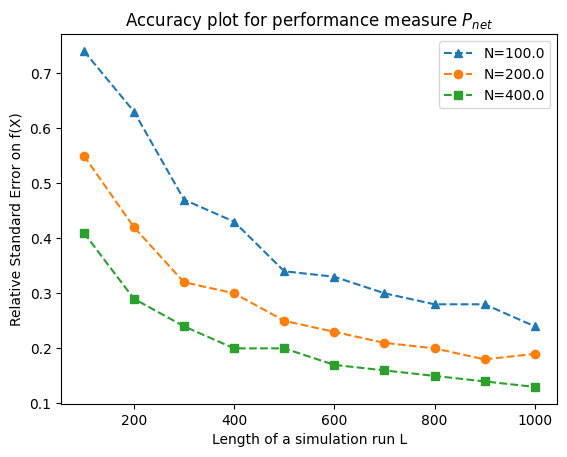

In [19]:
# this snippet is o plot RSE ve exe time of simulation (to get output performance measures at a single point)
# data is copied from 'exe_time_rse_ana.csv'
# columns are 
# num of days (length of sim), num of sims, std deviation, std err, rse, mean, exe time

import numpy as np
import matplotlib.pyplot as plt
data = np.array(([[100,100,200.22,20.02,0.74,2691.1,15.34],
                    [200,100,169.11,16.91,0.63,2682.74,46.06],
                    [300,100,123.78,12.38,0.47,2645.18,91.88],
                    [400,100,112.09,11.21,0.43,2626.25,153.07],
                    [500,100,91.42,9.14,0.34,2651.75,229.66],
                    [600,100,86.6,8.66,0.33,2646.87,321.62],
                    [700,100,78.25,7.83,0.3,2646.32,428.79],
                    [800,100,75.28,7.53,0.28,2650.46,551.35],
                    [900,100,73.72,7.37,0.28,2637.3,689.12],
                    [1000,100,64.55,6.45,0.24,2644.76,842.34],
                    [100,200,210.68,14.9,0.55,2689.76,30.6],
                    [200,200,158.74,11.22,0.42,2667.03,91.54],
                    [300,200,121.03,8.56,0.32,2643.98,183.1],
                    [400,200,113.6,8.03,0.3,2653.52,305.33],
                    [500,200,95.24,6.73,0.25,2643.38,458.02],
                    [600,200,86.65,6.13,0.23,2632.24,641.02],
                    [700,200,80.22,5.67,0.21,2639.08,855.21],
                    [800,200,76.32,5.4,0.2,2646.33,1100.73],
                    [900,200,67.64,4.78,0.18,2645.1,1375.73],
                    [1000,200,69.43,4.91,0.19,2648.62,1681.55],
                    [100,400,217.39,10.87,0.41,2648.08,55.95],
                    [200,400,152.86,7.64,0.29,2667.84,179.29],
                    [300,400,127.55,6.38,0.24,2653.18,358.23],
                    [400,400,107.77,5.39,0.2,2642.32,599.78],
                    [500,400,105.19,5.26,0.2,2642.48,877.62],
                    [600,400,91.39,4.57,0.17,2631.46,1248.96],
                    [700,400,82.31,4.12,0.16,2649.46,1682.13],
                    [800,400,79.17,3.96,0.15,2643.67,2176.54],
                    [900,400,73.71,3.69,0.14,2645.19,2733.22],
                    [1000,400,67.76,3.39,0.13,2646.82,3353.42]]))
markers = ['^','o','s']
k=0
for i in [100,200,400]:
    temp = data[data[:,1]==i]
    #plt.figure()
    plt.plot(temp[:,0],temp[:,4],label="N="+str(temp[0,1]),marker=markers[k],linestyle="--")
    #if(i==80):
    #    for i in range(0,temp.shape[0]):
    #        plt.annotate("L="+str(temp[i,0]),(temp[i,6],temp[i,4]),textcoords="offset points",xytext=(10,0),ha='left')        
    k+=1
plt.xlabel("Length of a simulation run L")
plt.ylabel("Relative Standard Error on f(X)")
plt.legend()
plt.title("Accuracy plot for performance measure $P_{net}$")
plt.show()


In [4]:
#euclidean dist

import math
actual_x = [320,130,325,125,735,480,735,475]
optimum_X_found = [[25,"nn","COBYLA",329.750,114.520,352.290,152.690,717.720,481.150,717.330,373.490],
                   [25,"nn","Powell",300.001,120.928,361.675,180.092,750.000,500.000,750.000,369.413],
                   [25,"nn","SLSQP",317.213,134.314,419.774,239.241,750.000,500.000,750.000,350.000],
                   [50,"nn","COBYLA",366.540,113.780,436.910,232.090,706.490,409.640,694.000,459.610],
                   [50,"nn","Powell",301.831,117.269,300.000,120.290,750.000,500.000,750.000,500.000],
                   [50,"nn","SLSQP",300.000,117.303,300.000,119.816,750.000,500.000,750.000,500.000],
                   [75,"nn","COBYLA",402.460,183.820,332.360,165.020,732.190,486.980,737.390,420.690],
                   [75,"nn","Powell",357.027,175.959,354.568,171.314,750.000,358.468,750.000,451.928],
                   [75,"nn","SLSQP",412.118,243.819,354.675,194.919,750.000,499.998,750.000,500.000],
                   [25,"gpr","COBYLA",317.520,125.151,319.298,123.479,621.708,372.346,732.068,476.603],
                   [25,"gpr","Powell",320.861,124.320,320.838,126.309,730.423,478.239,731.040,477.888],
                   [25,"gpr","SLSQP",317.519,125.150,319.297,123.478,621.707,372.346,732.068,476.602],
                   [25,"gpr","Nelder-Mead",318.693,129.348,318.972,125.505,732.445,374.372,731.916,478.672],
                   [50,"gpr","COBYLA",320.060,127.530,319.533,124.035,730.331,371.247,732.050,477.616],
                   [50,"gpr","Powell",321.348,124.780,319.450,124.224,730.948,479.679,731.242,478.044],
                   [50,"gpr","SLSQP",320.060,127.530,319.534,124.035,730.330,371.247,732.050,477.616],
                   [50,"gpr","Nelder-Mead",320.060,127.530,319.533,124.035,730.331,371.247,732.050,477.616],
                   [75,"gpr","COBYLA",320.103,123.911,320.496,123.196,621.141,371.478,730.841,477.294],
                   [75,"gpr","Powell",320.464,124.643,319.492,123.550,731.016,478.438,730.760,477.906],
                   [75,"gpr","SLSQP",320.102,123.911,320.496,123.197,621.142,371.478,730.841,477.295],
                   [75,"gpr","Nelder-Mead",320.464,124.643,319.493,123.550,731.016,478.438,730.760,477.906]]

for x in optimum_X_found:
    print(math.dist(x[3:],actual_x))

112.97169114428621
129.85014379275827
196.30205073304762
184.6682918099369
51.13095952551643
51.84677101806824
119.84956695791602
149.1805142704636
169.36553036258587
156.52513107804765
10.005580442932837
156.5259376173802
105.95056493950372
109.09392439544926
10.019003193931047
109.09391708981761
109.09392439544926
157.55660266710504
10.299895387818278
157.5558824798363
10.299360659769155
